Useful Links:

Morphology with OpenCV: https://docs.opencv.org/3.4/d9/d61/tutorial_py_morphological_ops.html 

# Imports

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from google.colab import files
import matplotlib.patches as patches
import cv2
from google.colab.patches import cv2_imshow

#from osgeo import gdal
from PIL import Image, ImageOps

In [ ]:
#rm -rf Gold-Particle-Segmentation/
!git clone https://github.com/therealarman/Gold-Particle-Segmentation

Cloning into 'Gold-Particle-Segmentation'...
remote: Enumerating objects: 301, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 301 (delta 20), reused 78 (delta 17), pack-reused 217
Receiving objects: 100% (301/301), 382.10 MiB | 22.99 MiB/s, done.
Resolving deltas: 100% (83/83), done.
Checking out files: 100% (134/134), done.


# Mask Functions

In [ ]:
# Function to scale up coordinate data to match the actual images
def coordinateMultiply(data, x = 'X', y = 'Y', xn = 1789, yn = 1789):
  X = data[x]
  Y = data[y]

  xConv = X.multiply(xn)
  yConv = Y.multiply(yn)

  return(xConv, yConv)

In [ ]:
# Function to convert Tiff files to Numpy Arrays
def imToArray(url):
  im = Image.open(url)
  imarray = np.array(im)
  return(imarray)

# Function to convert Numpy Arrays (from first function) to Images
def imToImage(url):
  imarray = imToArray(url)
  img = Image.fromarray(imarray)
  return(img)

In [ ]:
def makeMask(imarray, x, y, thresh=168, s = 25):
  # Threshold image to make B&W mask
  mask = cv2.threshold(imarray,thresh,255, cv2.THRESH_BINARY)[1]
  mask = 255 - mask

  # Create blank array with dimensions of original
  output = np.zeros_like(imarray, dtype=np.uint8)
  output[:,:] = 0

  # Get coordinates for rectangles around each gold particle
  for i in range(len(x)):
    tx = int(y[i] - (s/2))
    ly = int(x[i] - (s/2))
    bx = int(y[i] + (s/2))
    ry = int(x[i] + (s/2))
  
    # Copy rectangle coords from original to blank array
    output[tx:bx,ly:ry] = mask[tx:bx,ly:ry]

  # Blend output array with original image
  cv2.addWeighted(imarray, 0, output, 1, 0, output);

  # Use erosion and dilation to remove excess noise from the output
  kernel = np.ones((5,5),np.uint8)
  opening = cv2.morphologyEx(output, cv2.MORPH_OPEN, kernel)

  # Overlay result on original image
  overlay = np.zeros_like(imarray, dtype=np.uint8)
  cv2.addWeighted(imarray, 1, opening, 0.5, 0, overlay);

  return(opening, overlay, output)

In [ ]:
# Same as previous function but generates an image with each step in the data processing progress
def maskPipeline(imarray, x, y, thresh=168, s = 25):

  mask = cv2.threshold(imarray,thresh,255, cv2.THRESH_BINARY)[1]
  mask = 255 - mask
  rectMask = mask.copy()

  output = np.zeros_like(imarray, dtype=np.uint8)
  output[:,:] = 0

  for i in range(len(x)):
    tx = int(y[i] - (s/2))
    ly = int(x[i] - (s/2))
    bx = int(y[i] + (s/2))
    ry = int(x[i] + (s/2))
  
    output[tx:bx,ly:ry] = mask[tx:bx,ly:ry]

    rectMask = cv2.rectangle(rectMask, (ly,tx), (ry,bx), (0,0,255), 2) # Used for generating bounding box images
    #imarray = cv2.circle(imarray, (int(x[i]),int(y[i])), 12, (255, 0, 0), 2)

  cv2.addWeighted(imarray, 0, output, 1, 0, output);

  kernel = np.ones((5,5),np.uint8)
  opening = cv2.morphologyEx(output, cv2.MORPH_OPEN, kernel)

  overlay = np.zeros_like(imarray, dtype=np.uint8)

  cv2.addWeighted(imarray, 1, opening, 0.5, 0, overlay);

  h_img = cv2.hconcat([imarray, mask, rectMask, output, opening])
  
  return(h_img)

In [ ]:
df = pd.read_csv(
    '/content/Gold-Particle-Segmentation/2022 analyzed synapses/S4/Results/Results 6nm XY in microns.csv'
    )
df = pd.DataFrame(df)
x, y = coordinateMultiply(df)

dataArray = imToArray(
    '/content/Gold-Particle-Segmentation/2022 analyzed synapses/S4/S4 MBTt FFRIL01 R1Bg1d Wt 8wk AMPA6nm_NR1_12nm_vGlut2_18nm S4.tif'
    )

#cv2_imshow(maskPipeline(dataArray, x, y))

x

0       633.306
1       660.141
2       738.857
3       762.114
4       790.738
         ...   
106     633.306
107     983.950
108     928.491
109    1450.879
110    1152.116
Name: X, Length: 111, dtype: float64

# Make Masks

In [ ]:
# Function that uses each other function to generate a mask from the files in GitHub
def getMask(id, thresh=168):
  df = pd.read_csv(
      '/content/Gold-Particle-Segmentation/Dataset/2022 Analyzed Synapses/'+id+'/Results/Results 6nm XY in microns.csv'
      )
  df = pd.DataFrame(df)
  x, y = coordinateMultiply(df)

  dataArray = imToArray(
      '/content/Gold-Particle-Segmentation/Dataset/2022 Analyzed Synapses/'+id+'/'+id+' MBTt FFRIL01 R1Bg1d Wt 8wk AMPA6nm_NR1_12nm_vGlut2_18nm '+id+'.tif'
      )

  op, ov, ot = makeMask(dataArray, x, y, thresh)
  return(op)

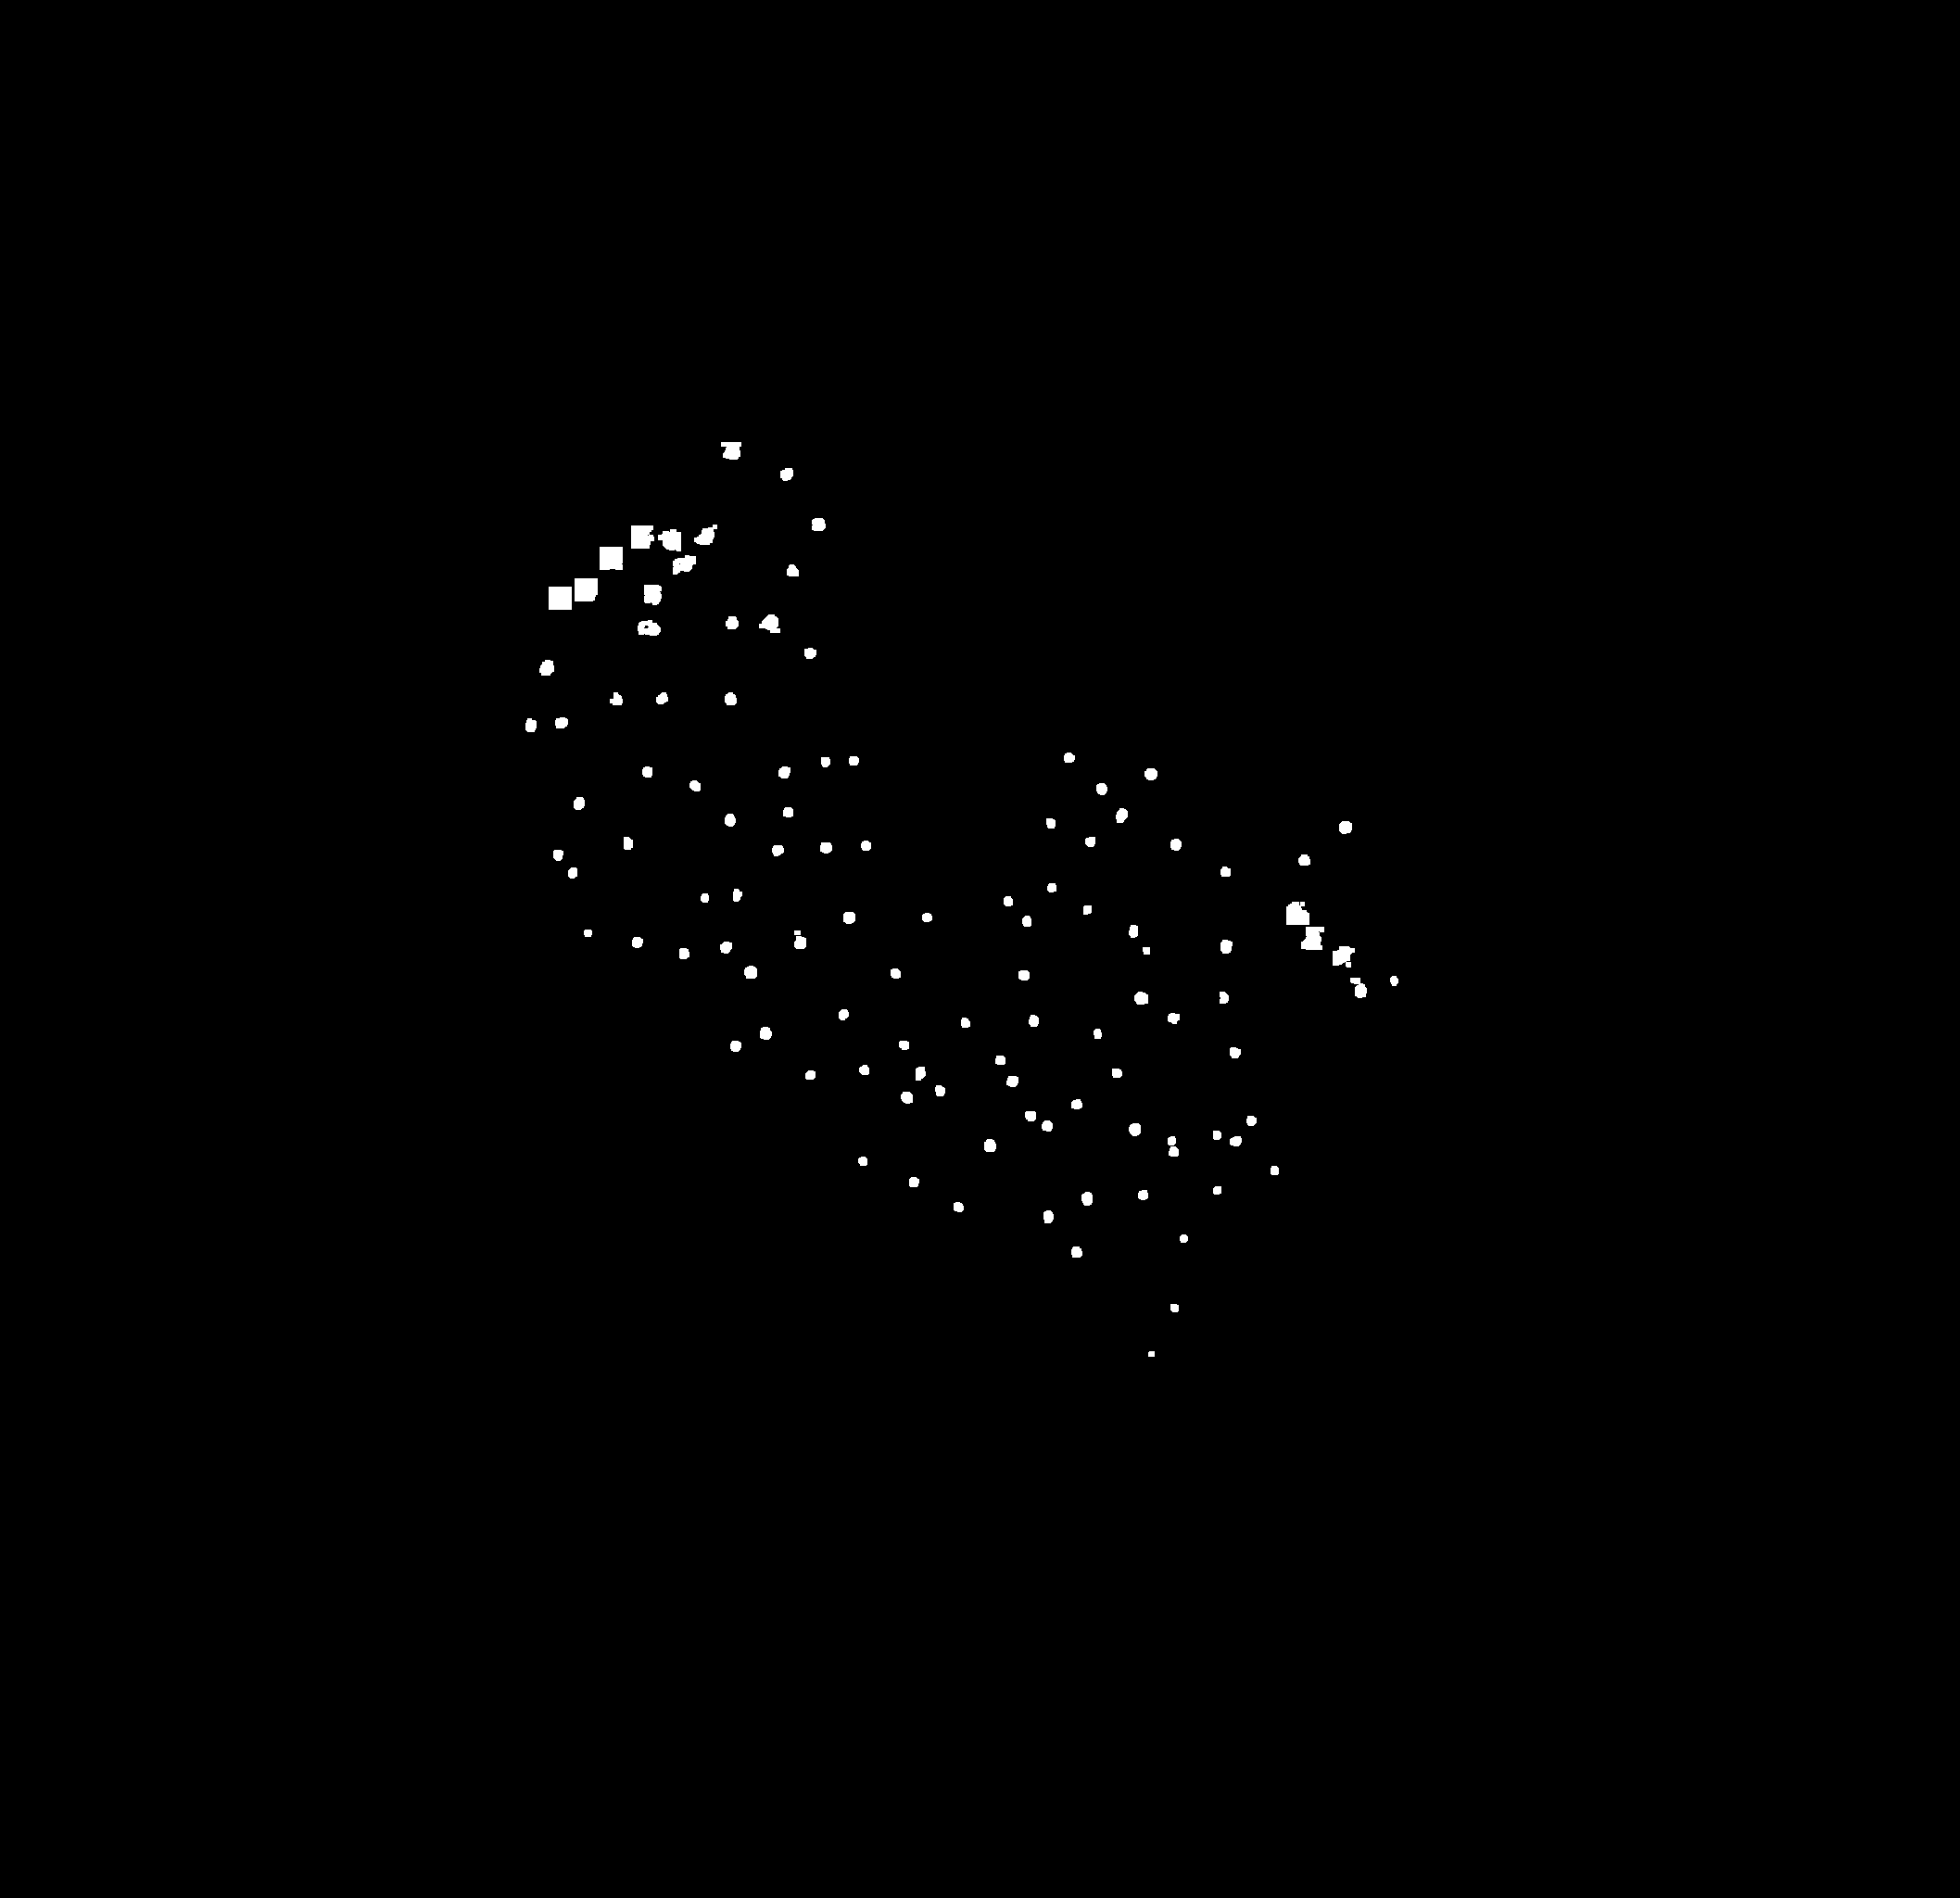

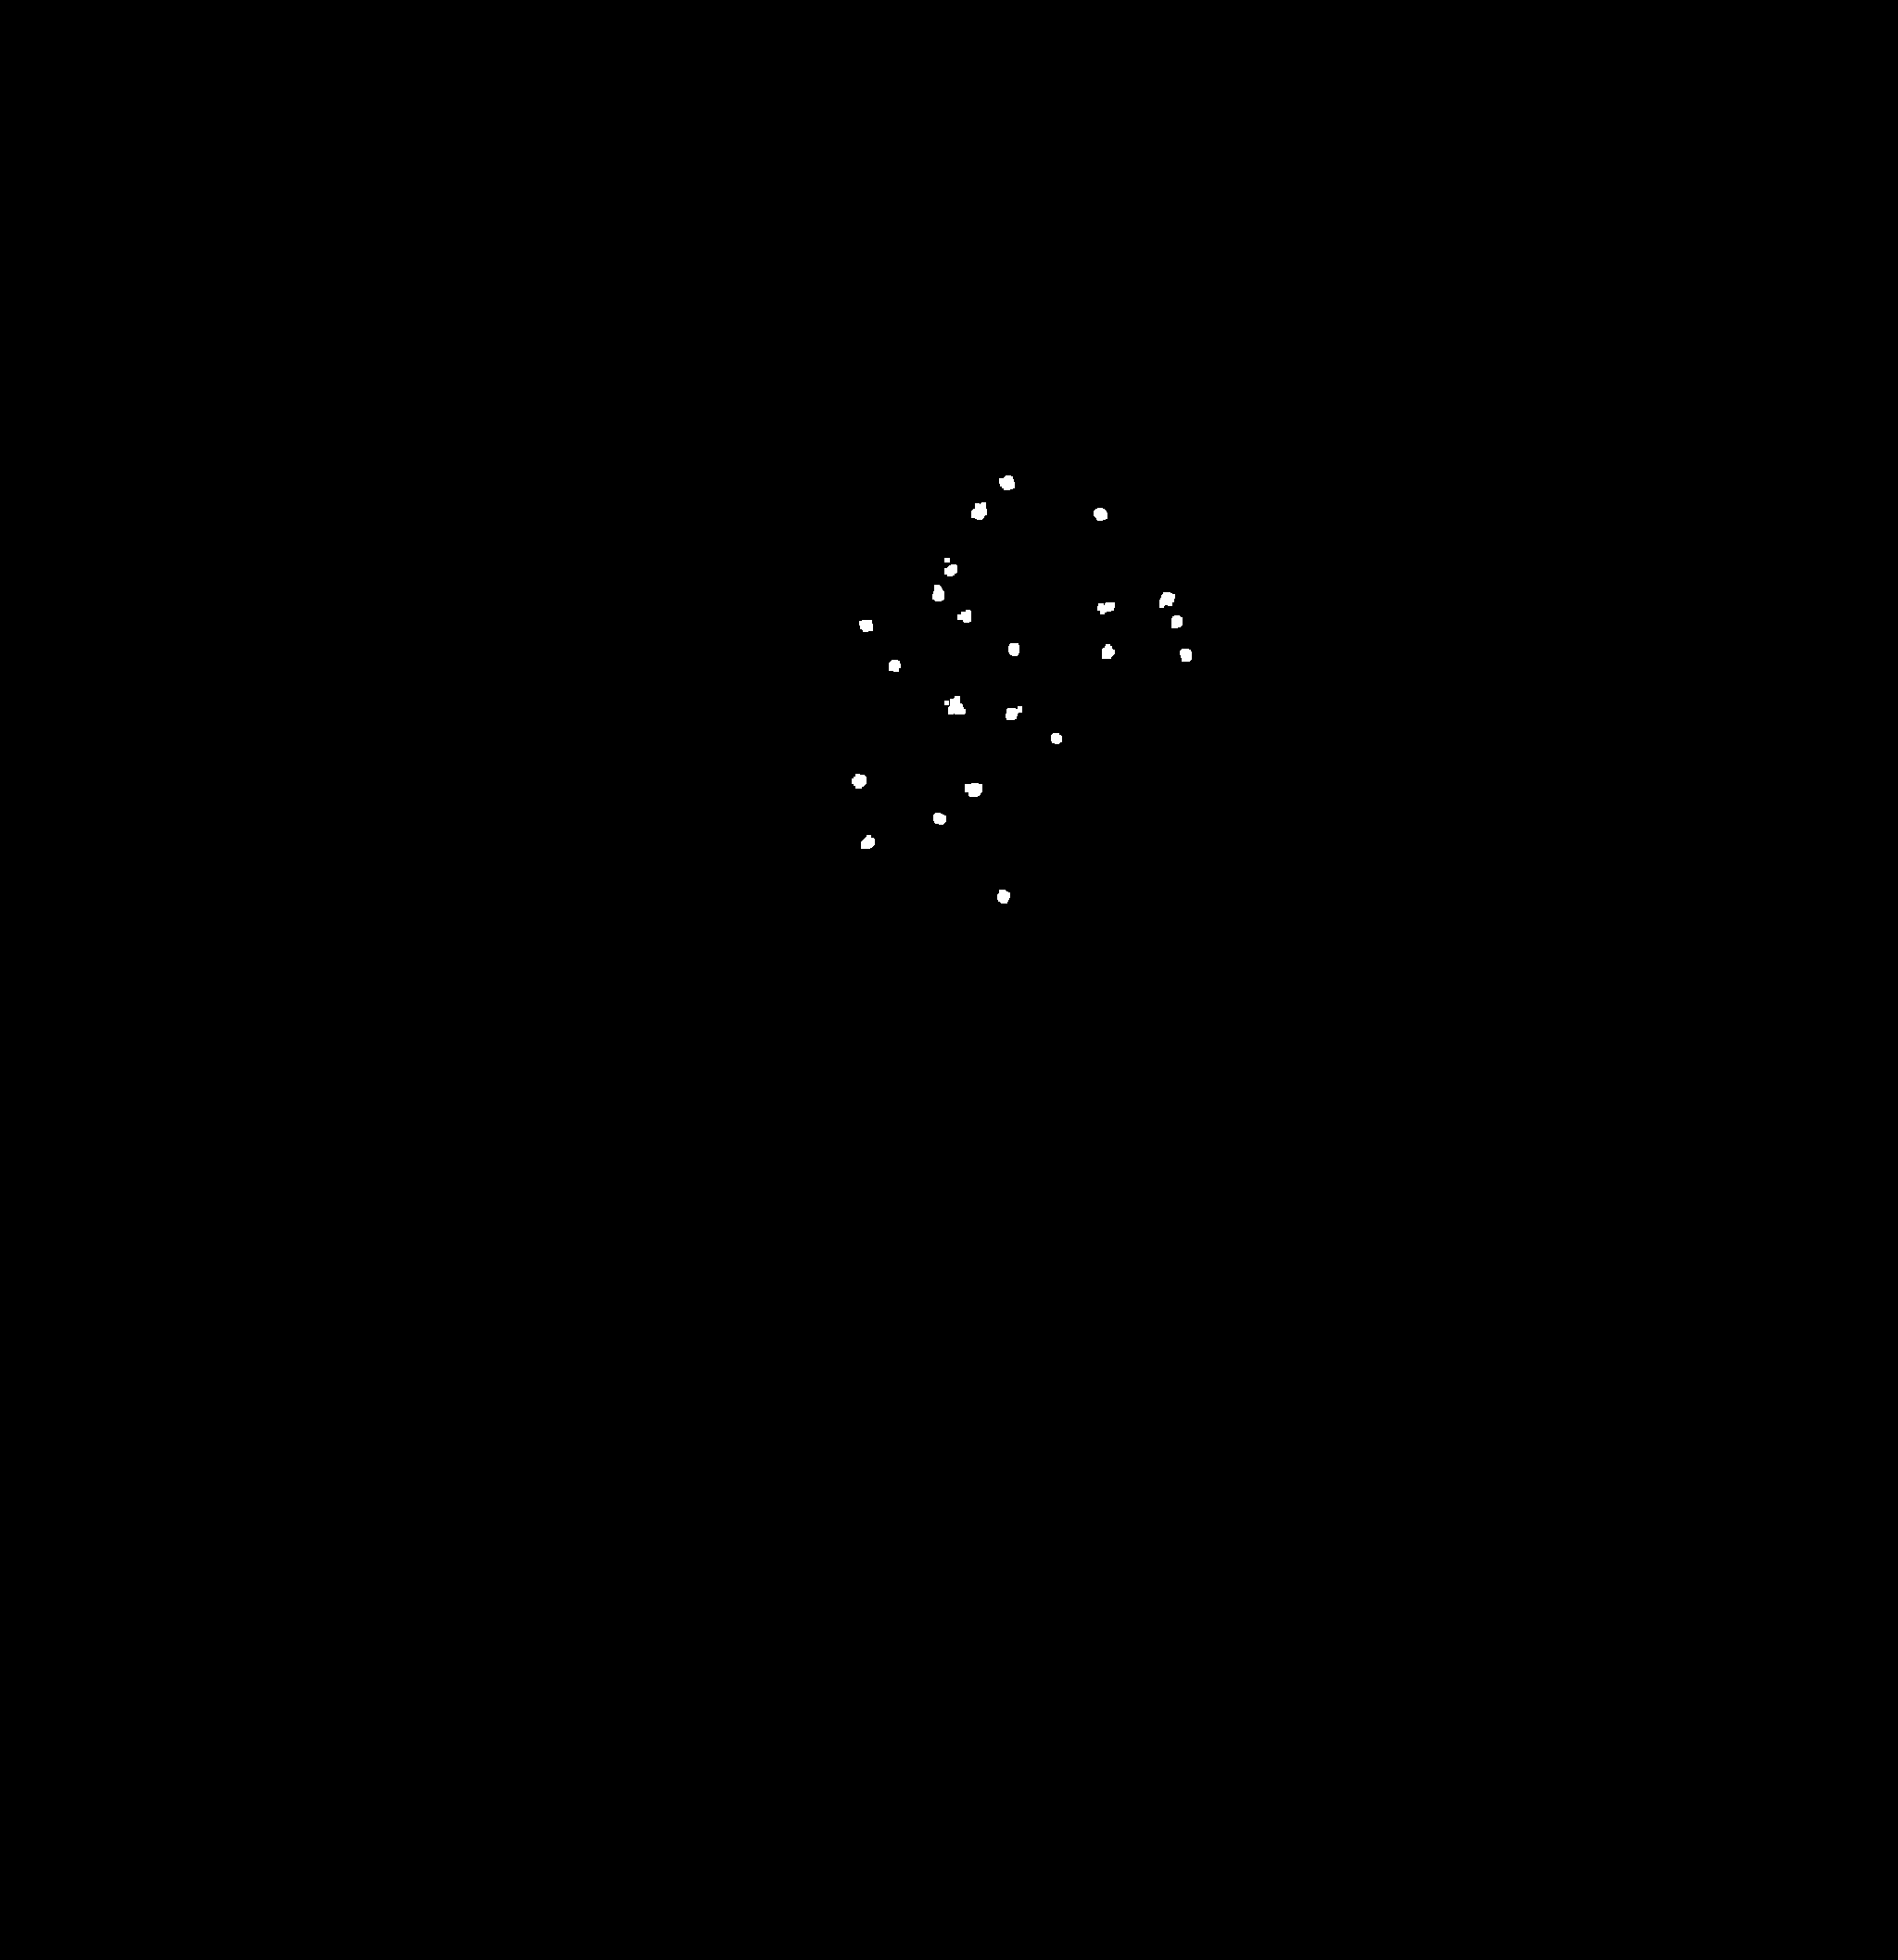

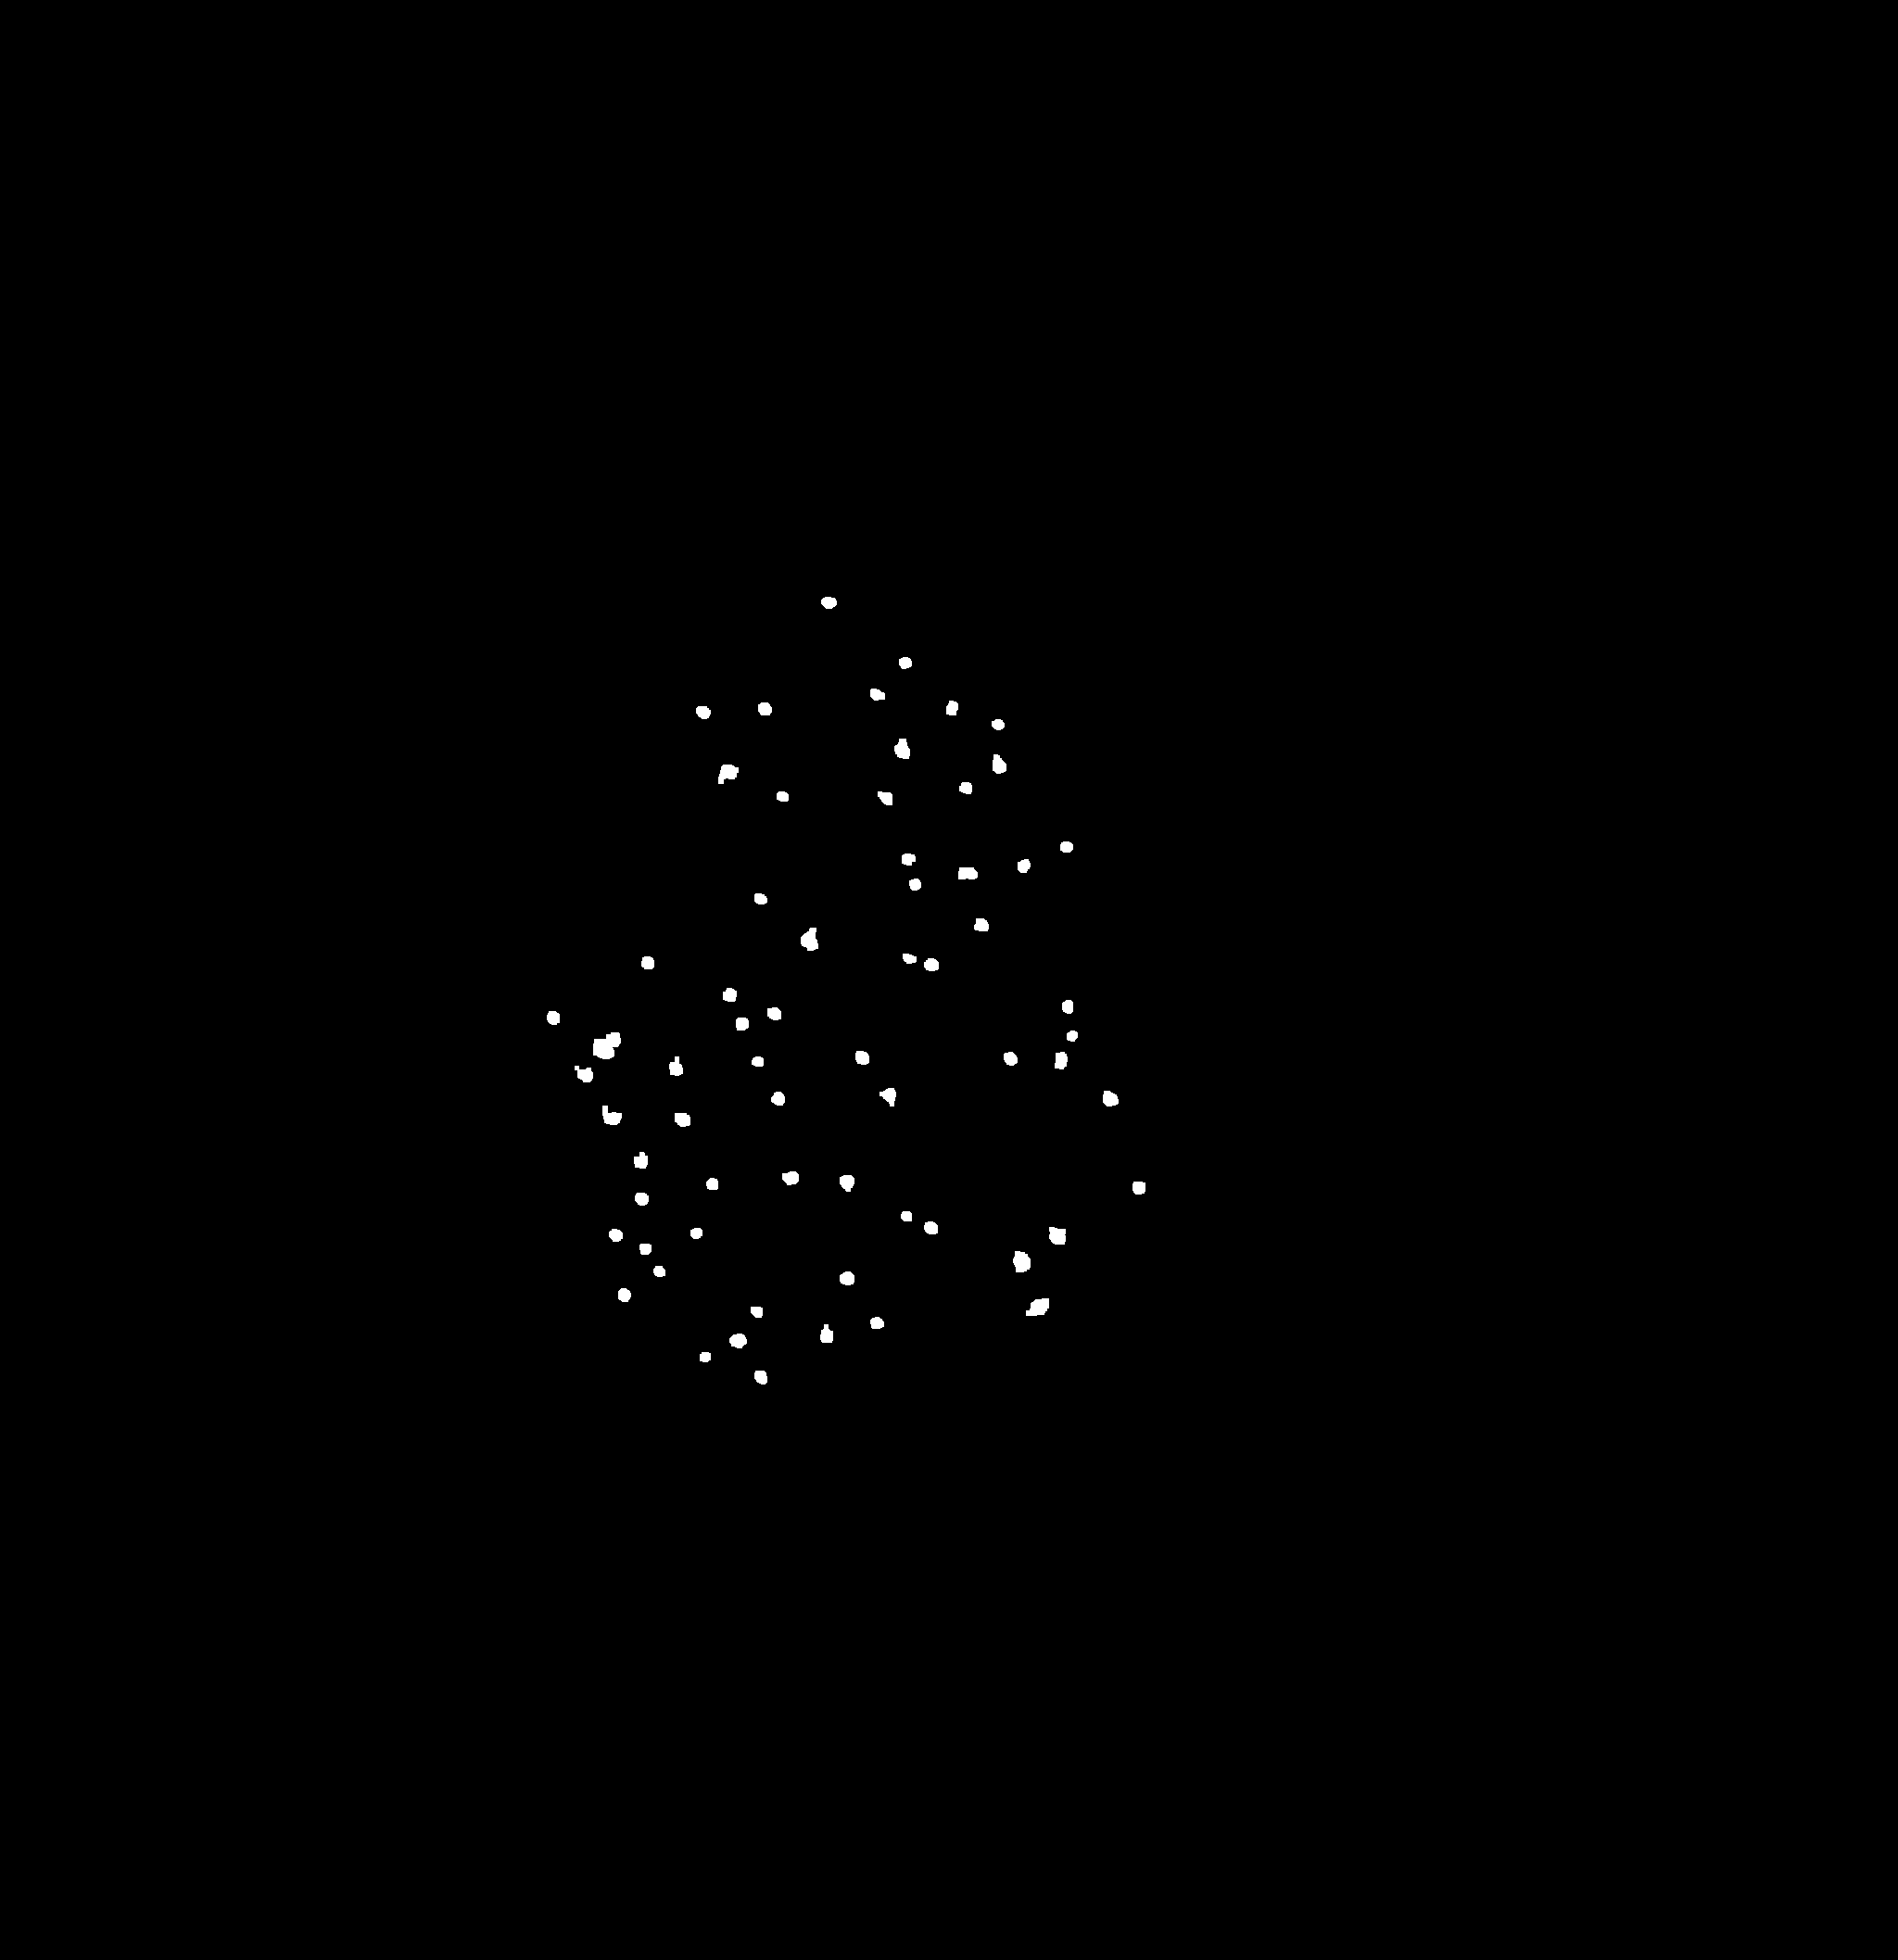

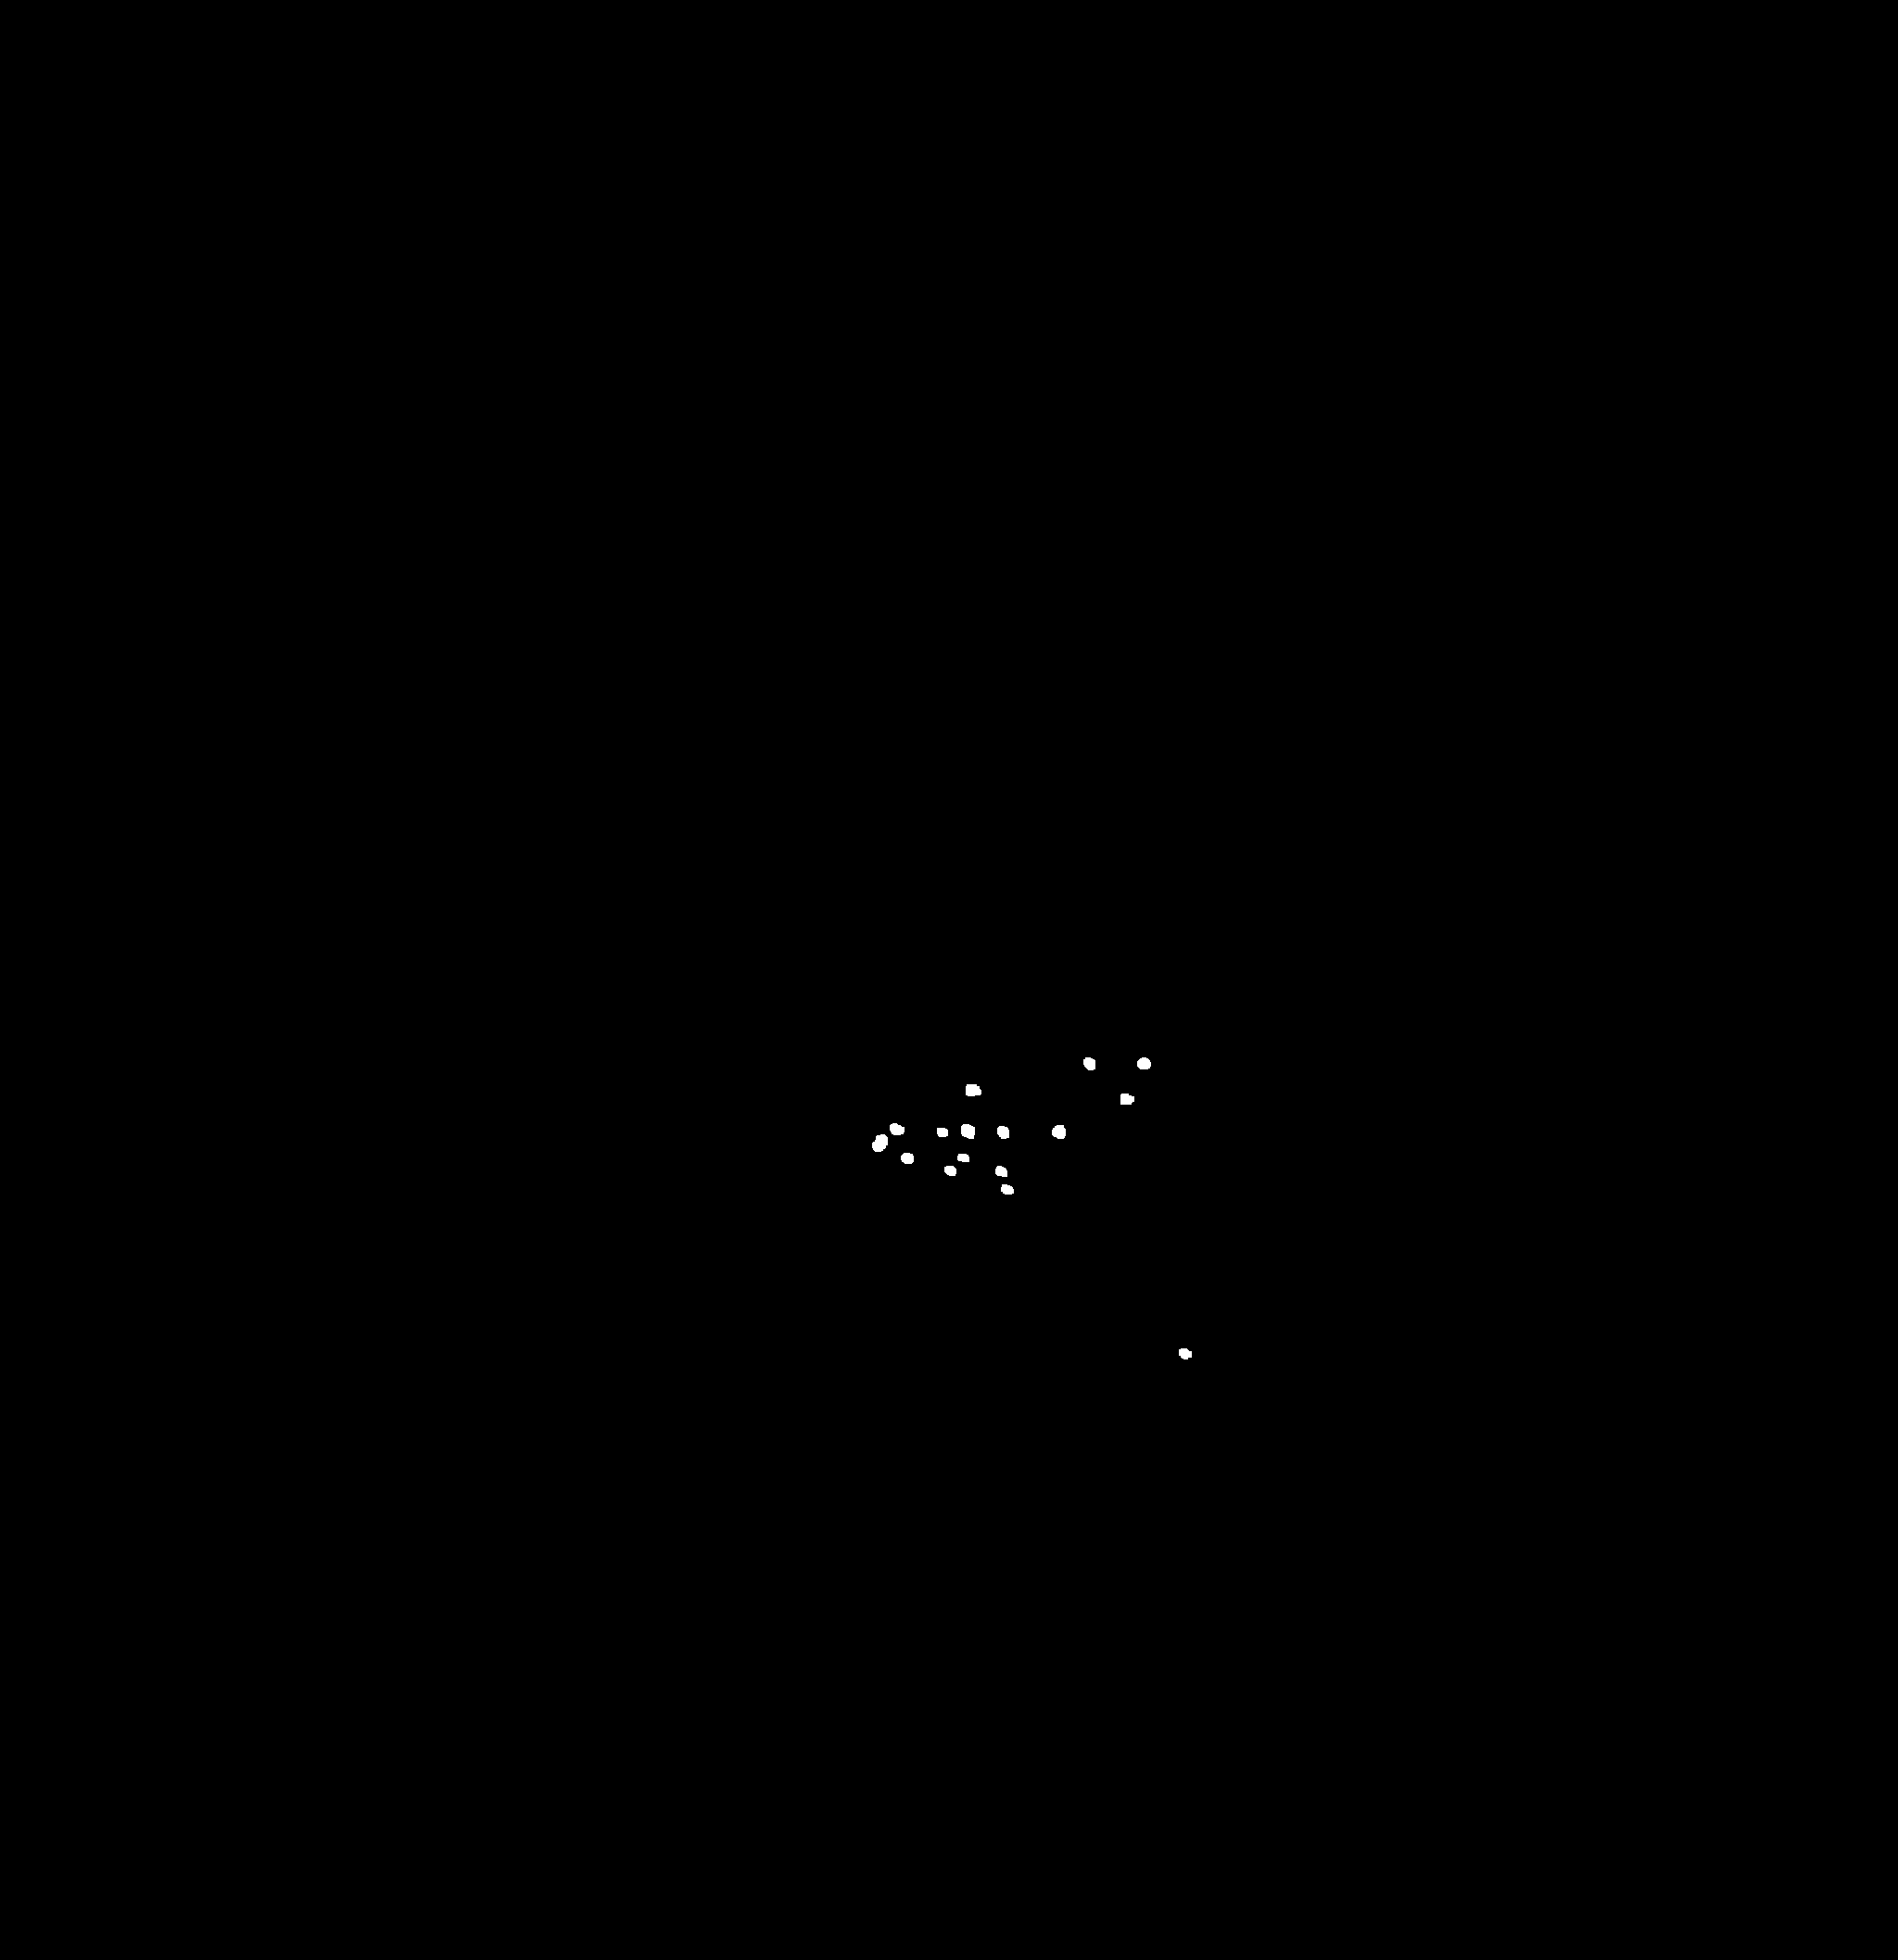

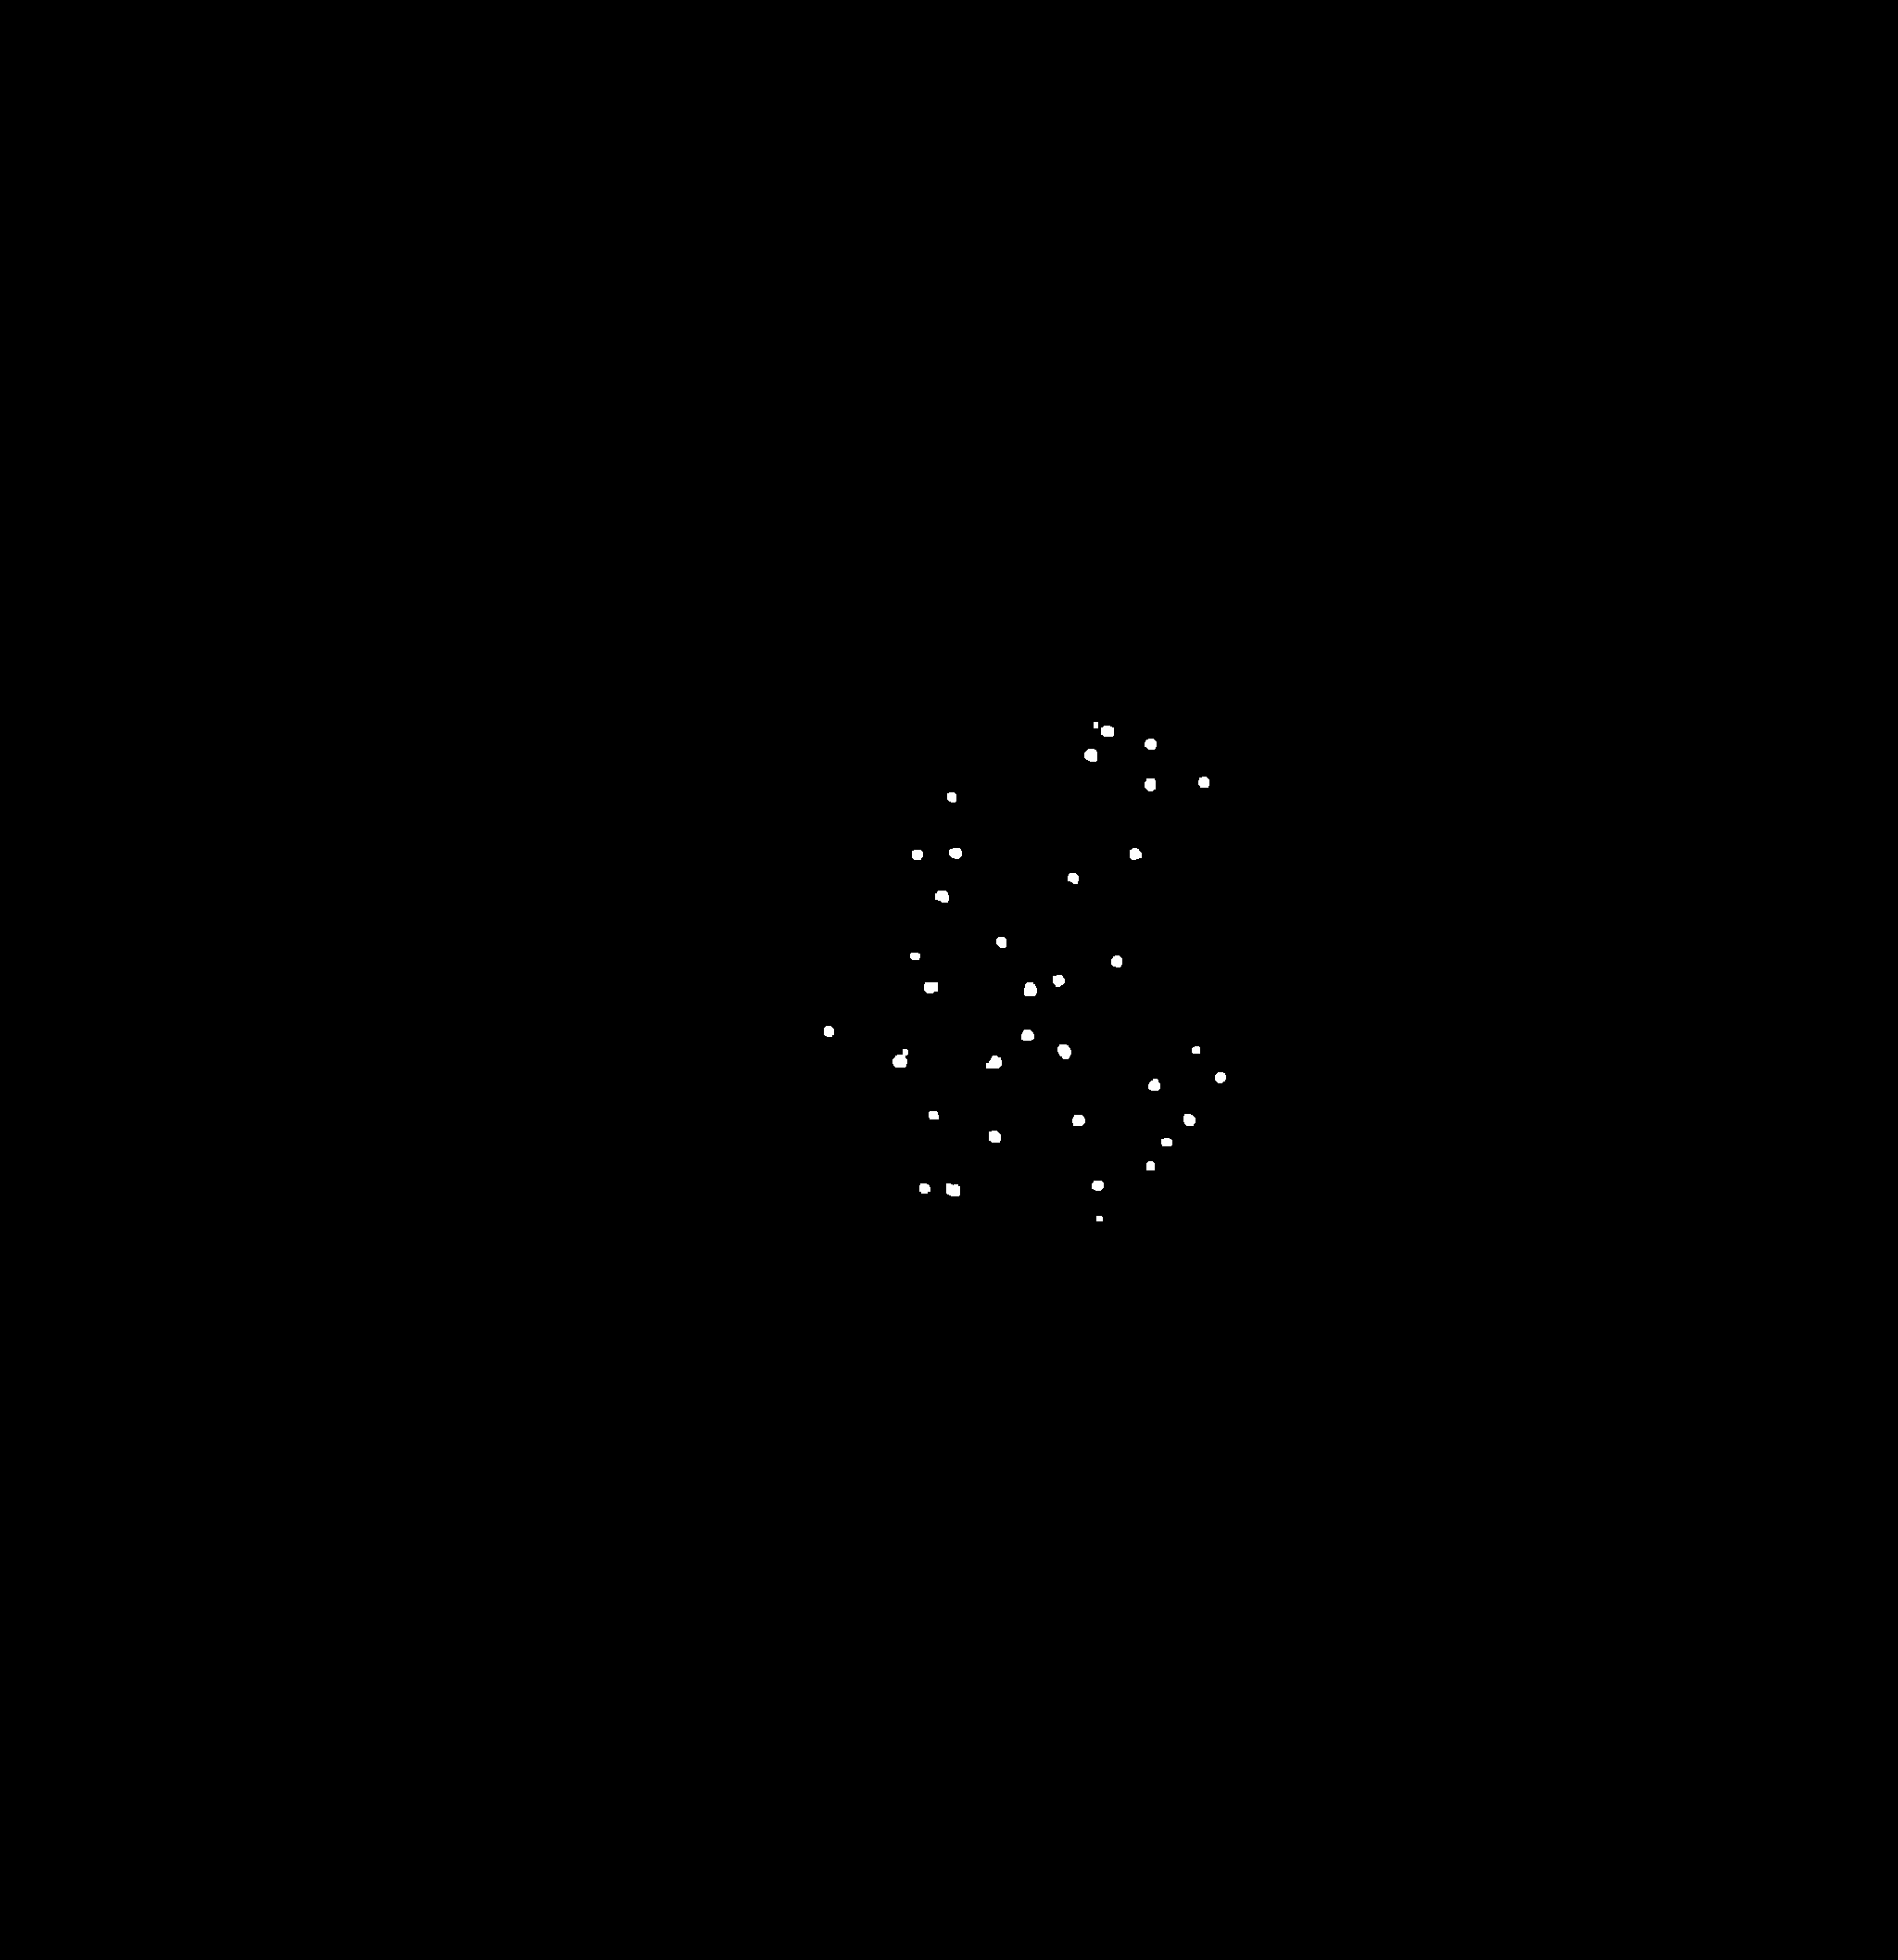

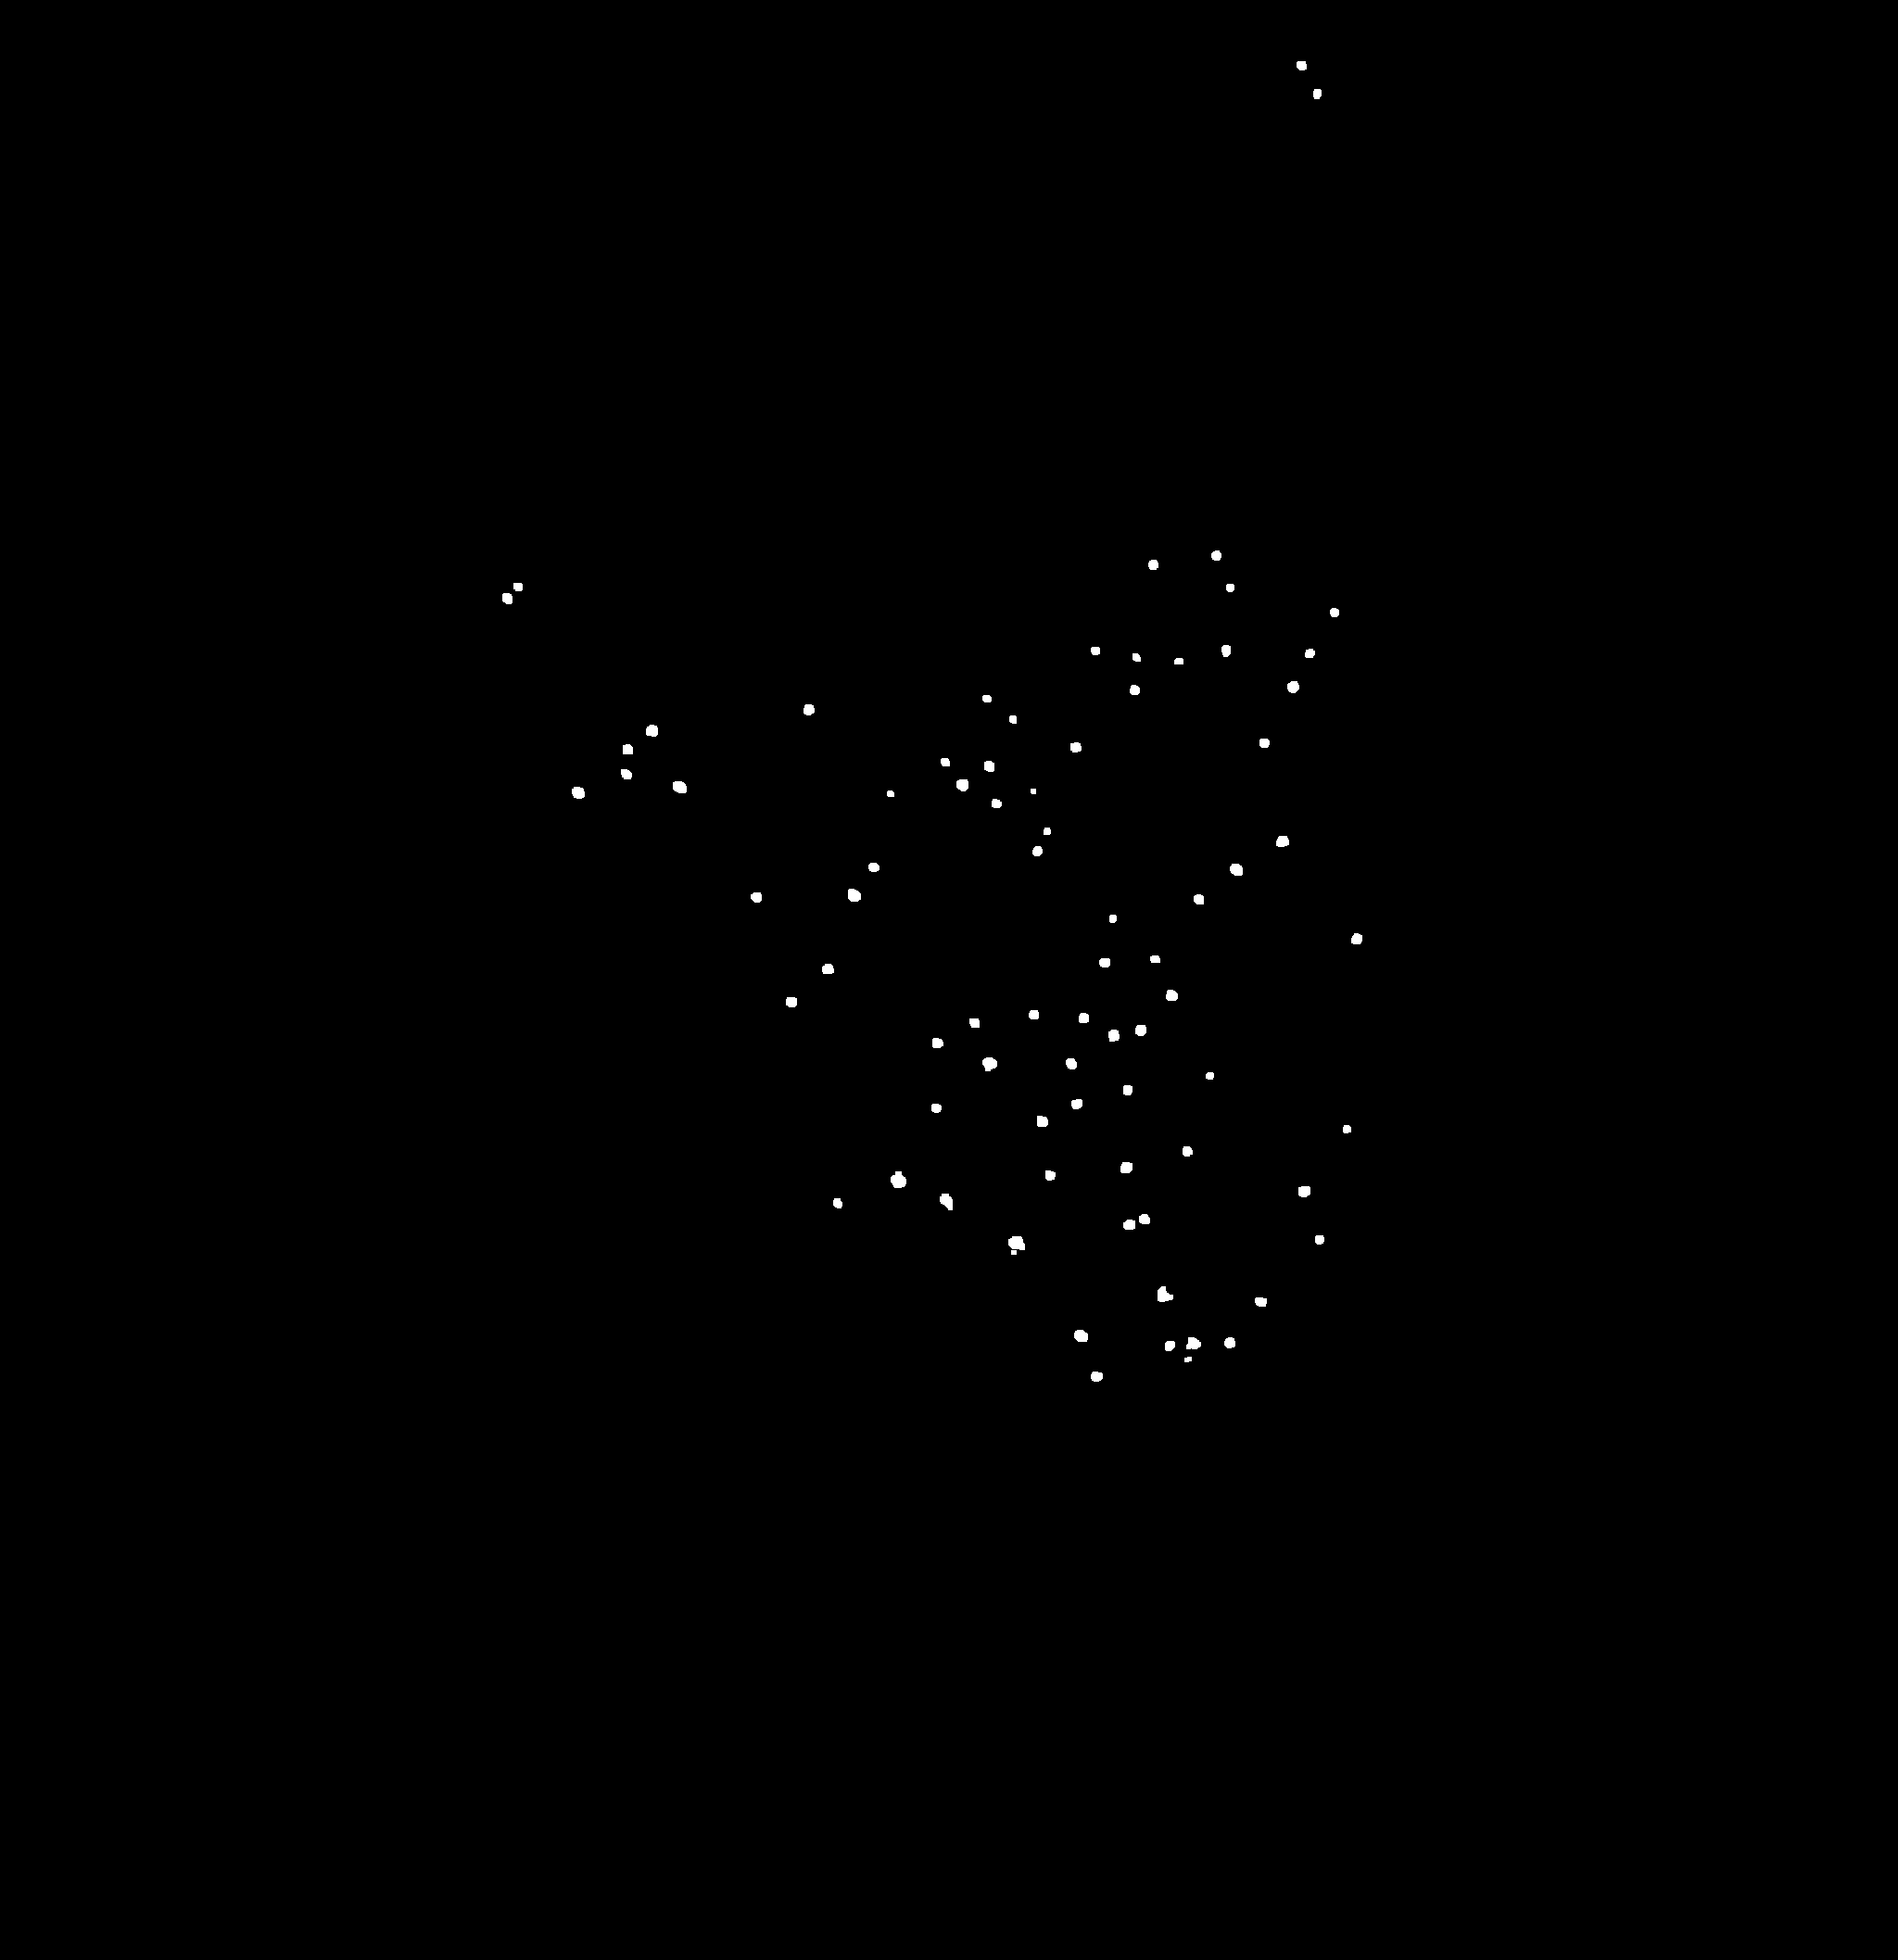

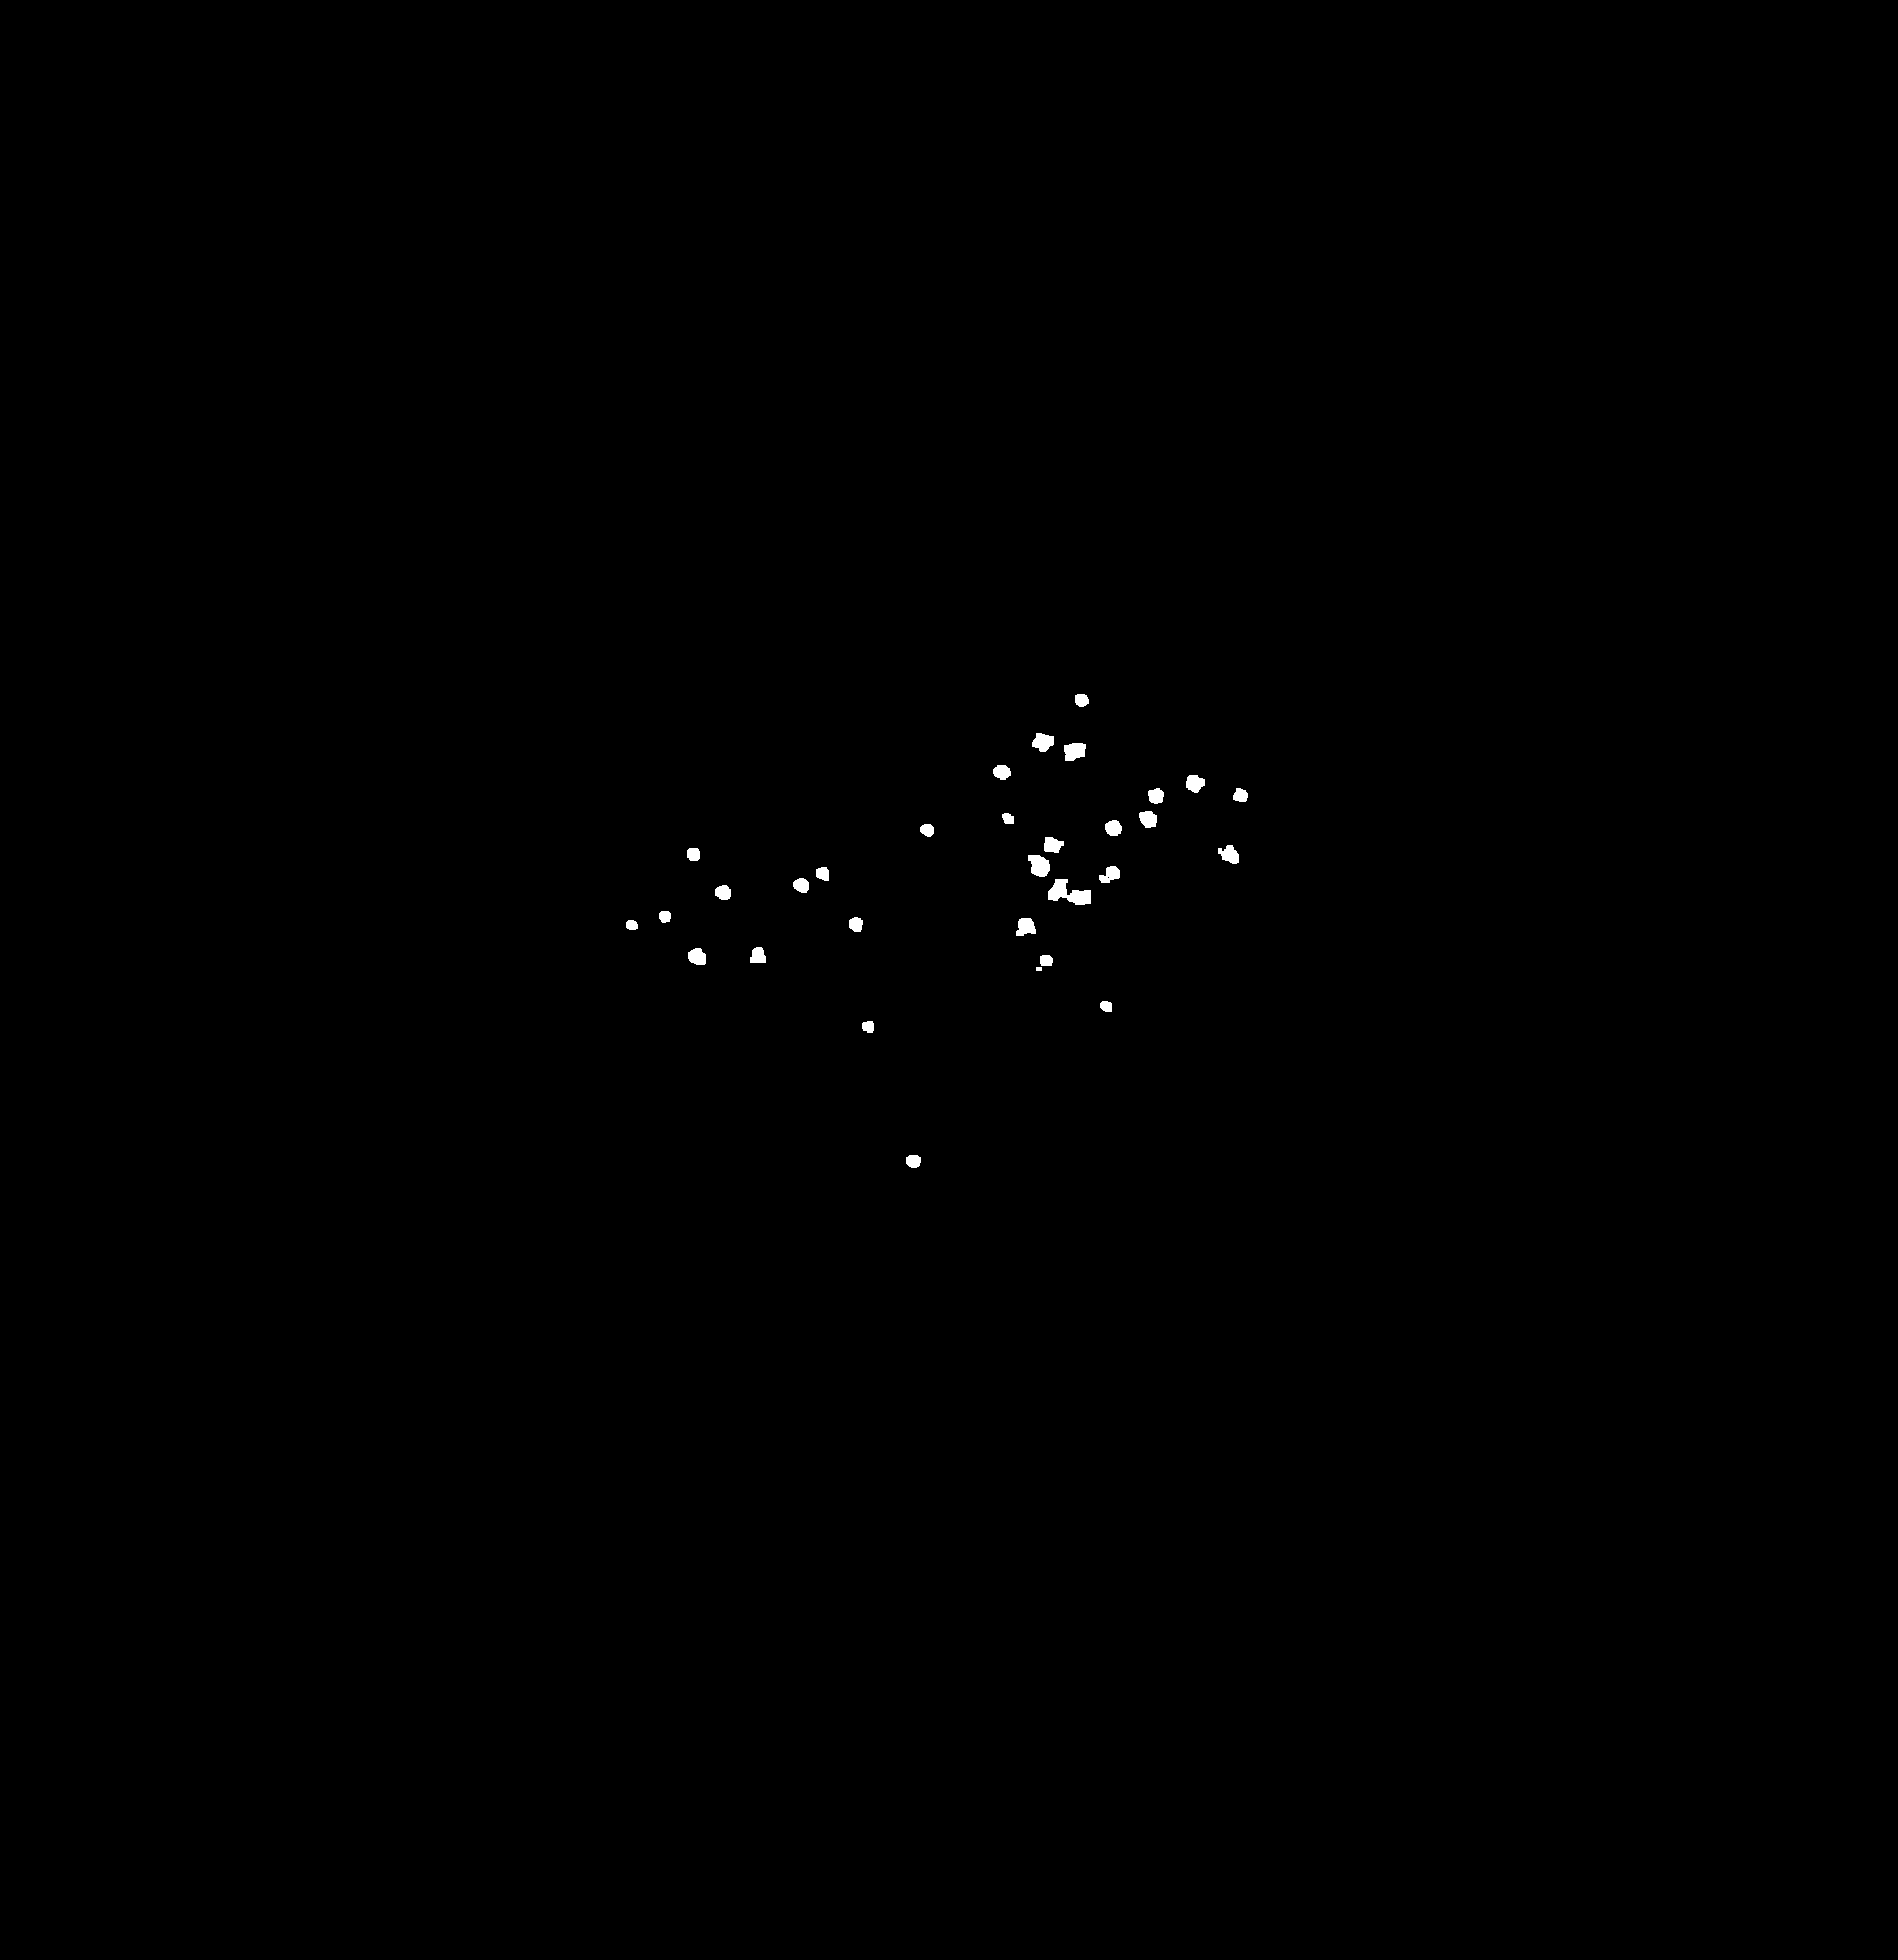

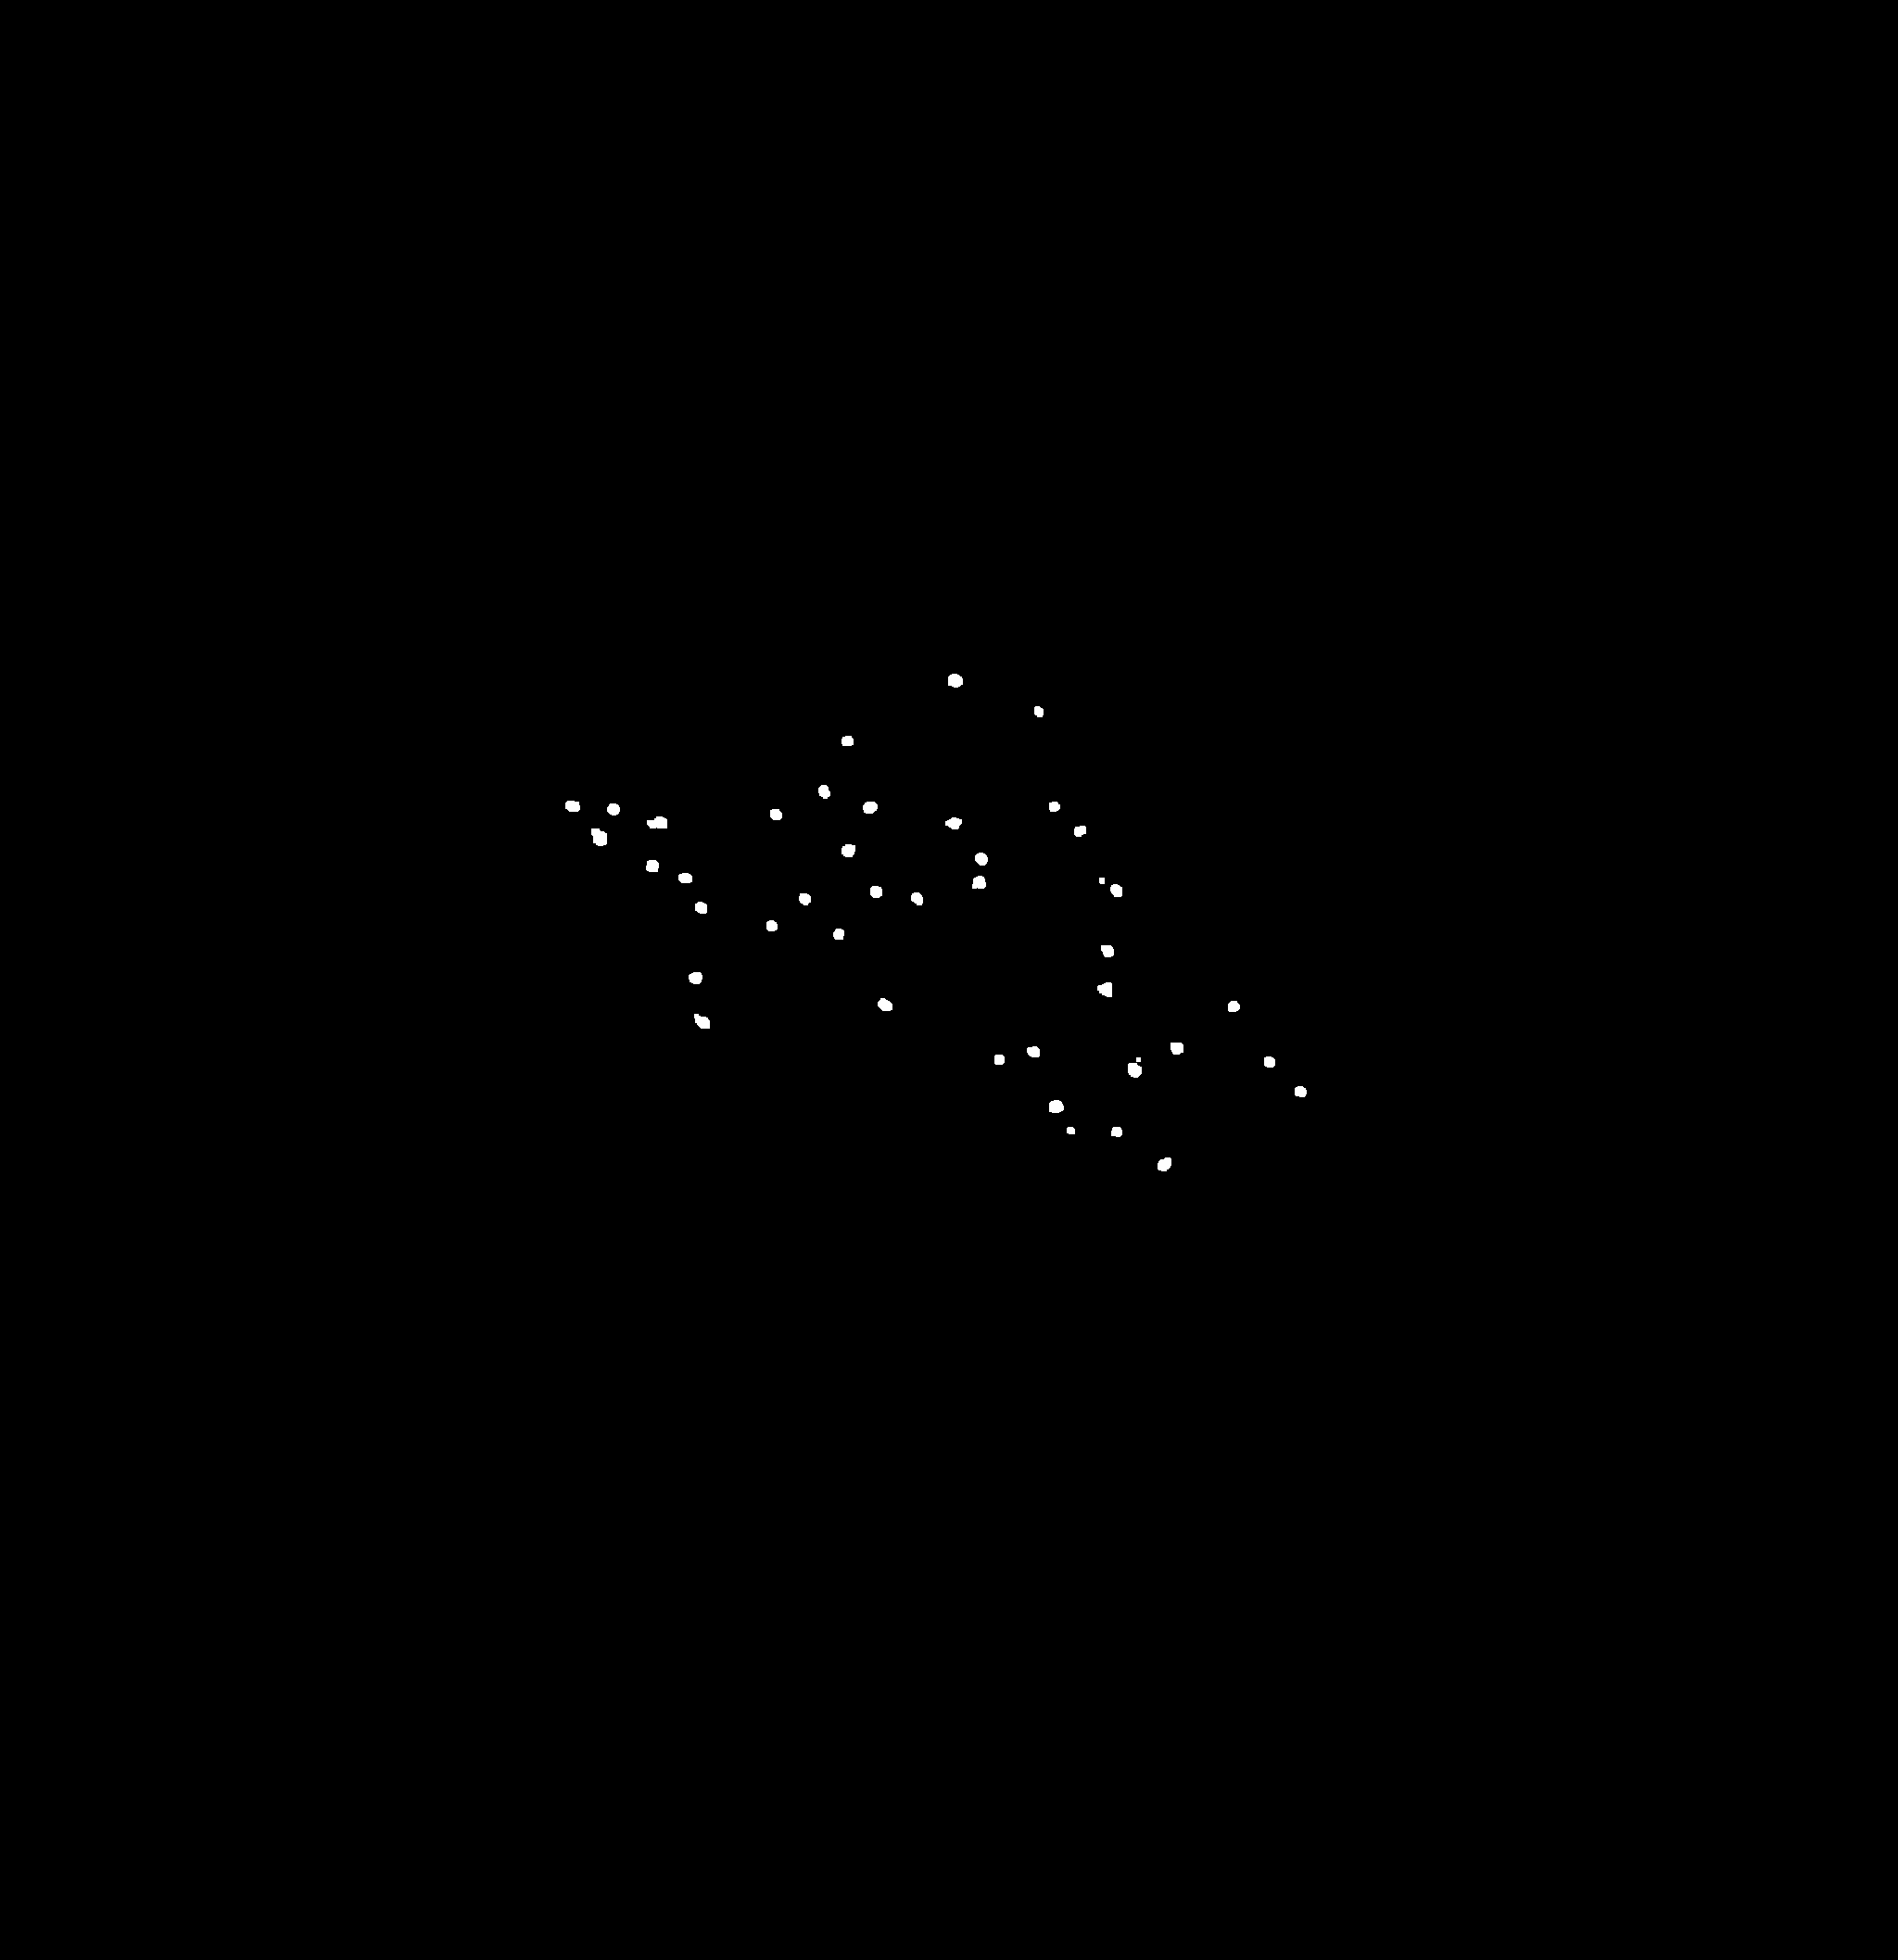

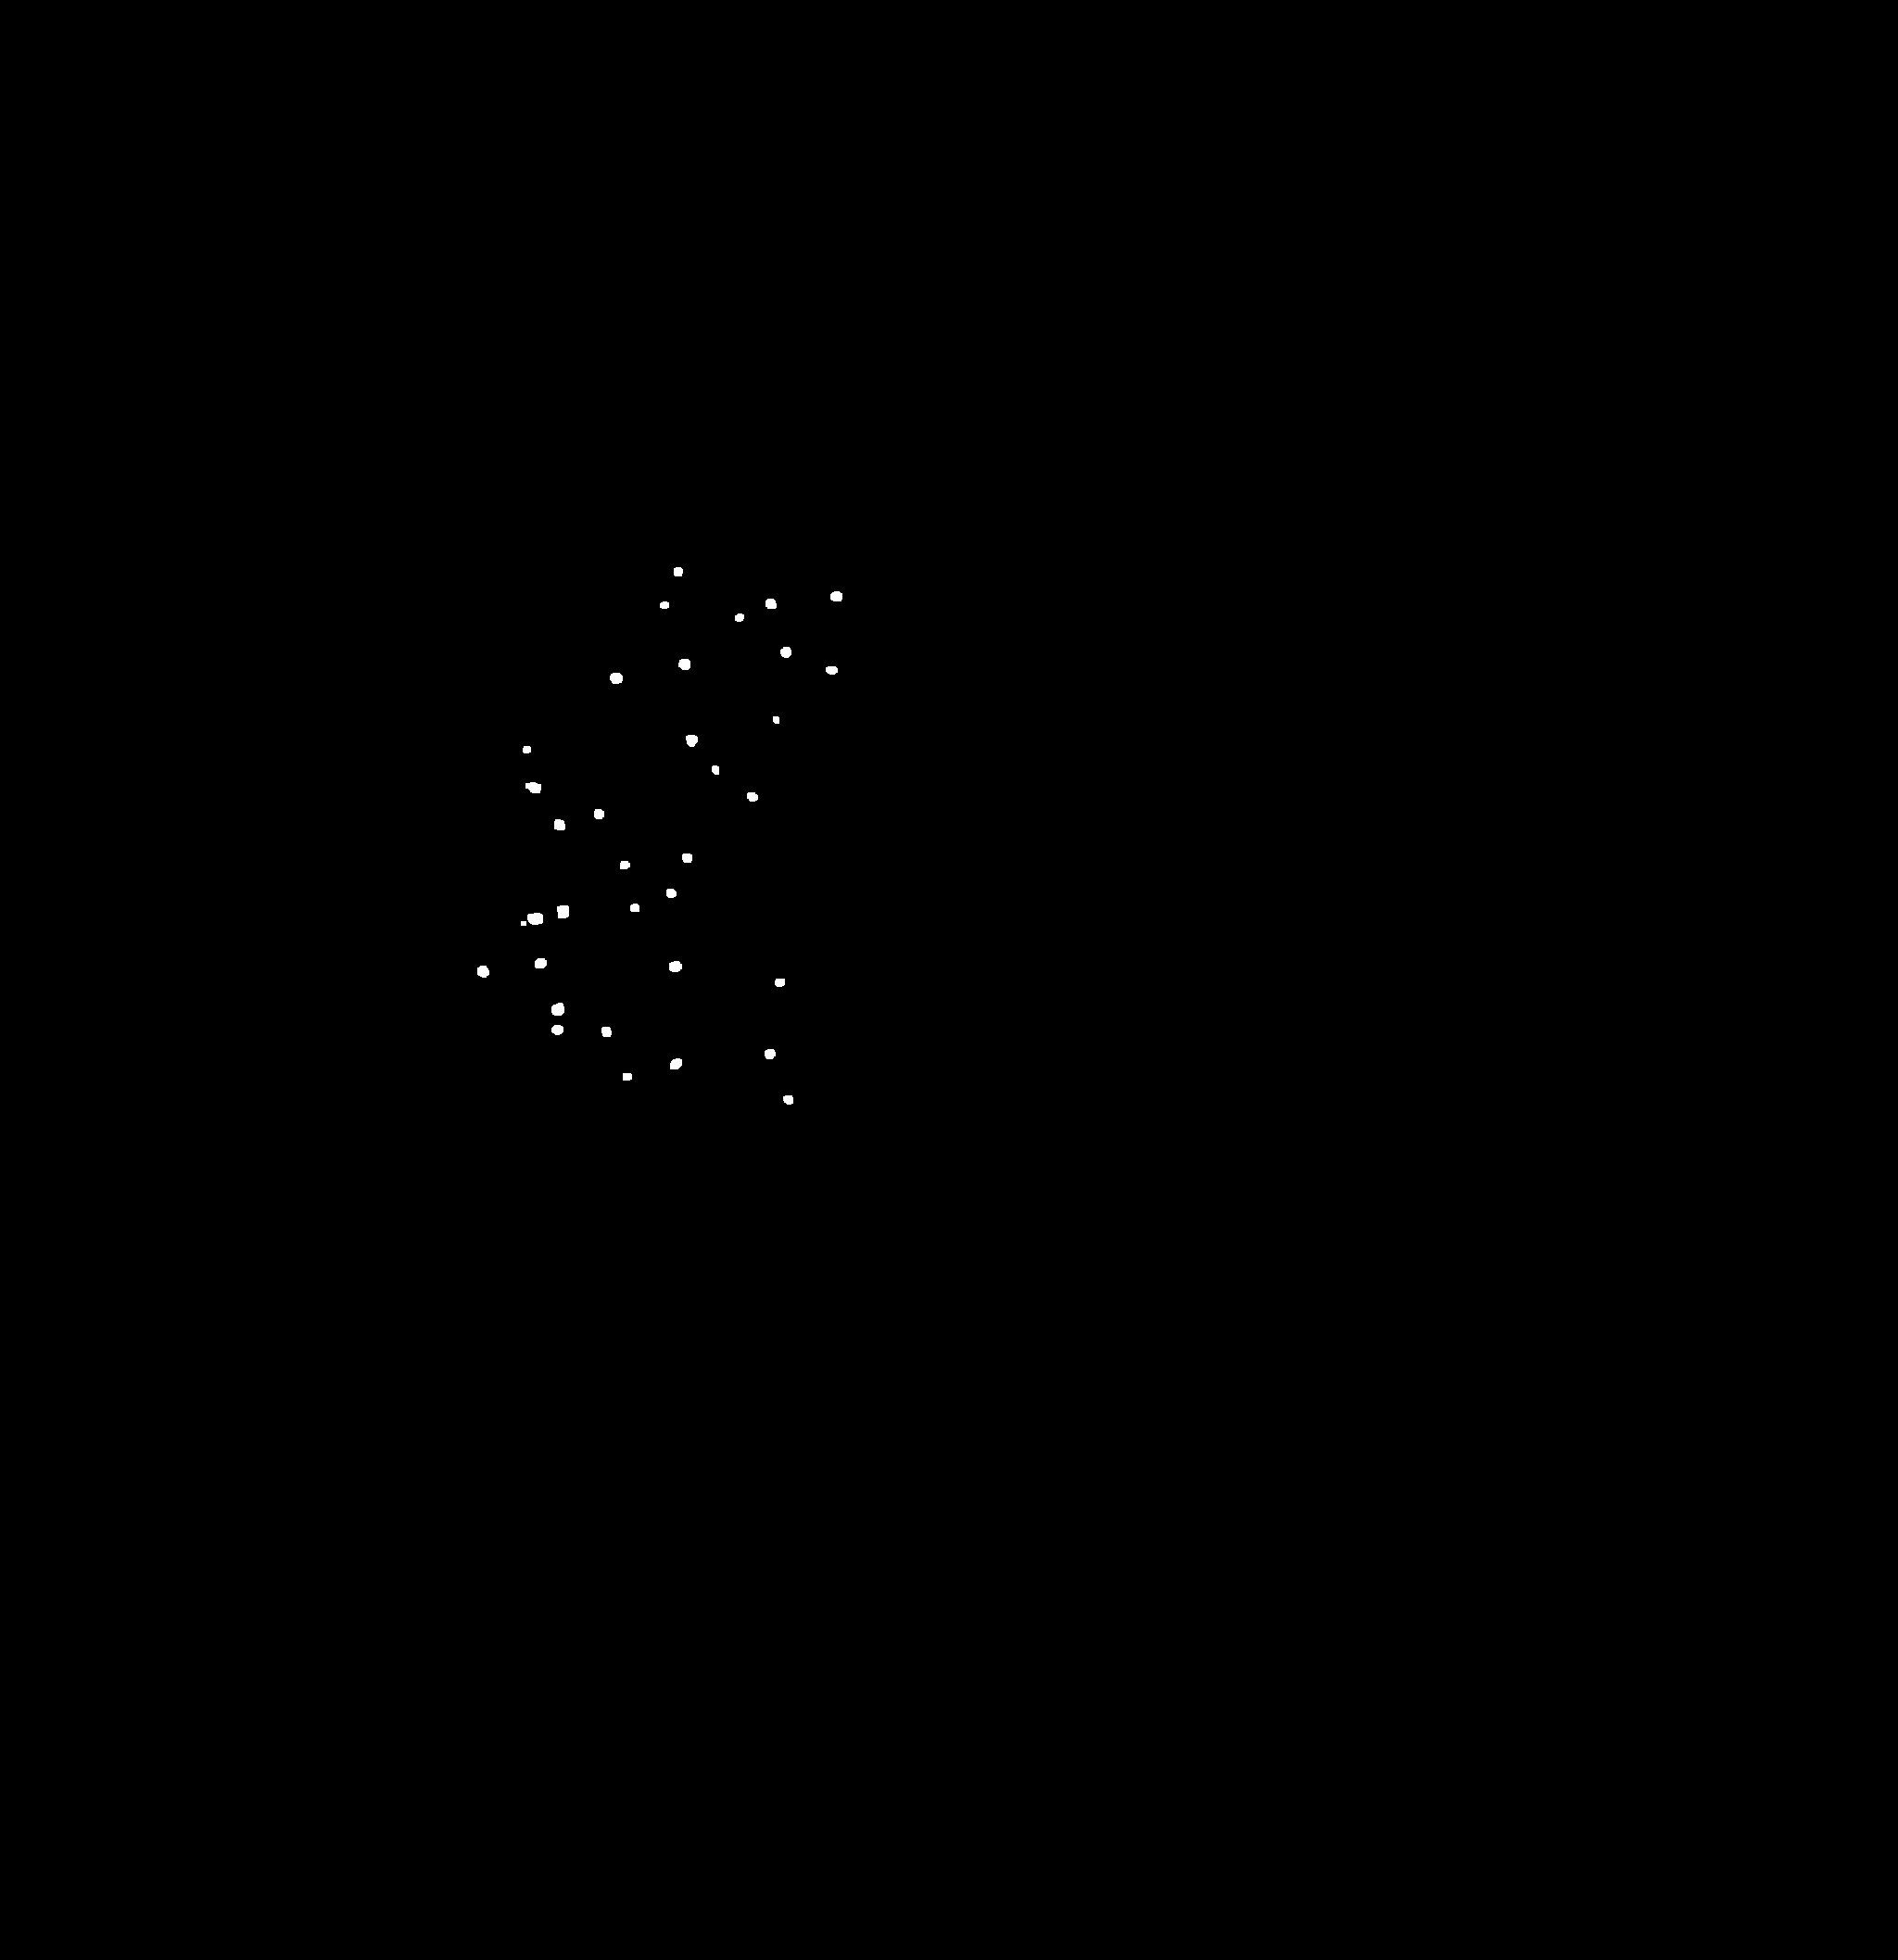

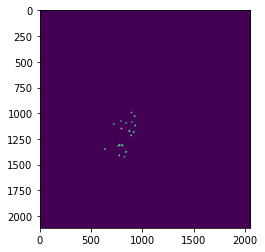

In [ ]:
# Save & Display each mask image
cv2.imwrite('S1_Mask.png', getMask('S1'))
cv2_imshow(getMask('S1'))
cv2.imwrite('S4_Mask.png', getMask('S4'))
cv2_imshow(getMask('S4'))
cv2.imwrite('S7_Mask.png', getMask('S7'))
cv2_imshow(getMask('S7'))
cv2.imwrite('S8_Mask.png', getMask('S8'))
cv2_imshow(getMask('S8'))
cv2.imwrite('S13_Mask.png', getMask('S13', 130))
cv2_imshow(getMask('S13', 130))
cv2.imwrite('S15_Mask.png', getMask('S15'))
cv2_imshow(getMask('S15'))

#22
#=====
df = pd.read_csv(
    '/content/Gold-Particle-Segmentation/Dataset/2022 Analyzed Synapses/S22/Results 2/Results 6nm XY in microns.csv'
    )
df = pd.DataFrame(df)
x, y = coordinateMultiply(df)

dataArray = imToArray(
    '/content/Gold-Particle-Segmentation/Dataset/2022 Analyzed Synapses/S22/S22 MBTt FFRIL01 R1Bg1d Wt 8wk AMPA6nm_NR1_12nm_vGlut2_18nm S22_0003.tif'
    )

op22, ov22, ot22 = makeMask(dataArray, x, y, 130)
cv2.imwrite('S22_Mask.png', op22)
cv2_imshow(op22)
#=====

cv2.imwrite('S25_Mask.png', getMask('S25', 110))
cv2_imshow(getMask('S25', 110))
cv2.imwrite('S27_Mask.png', getMask('S27'))
cv2_imshow(getMask('S27'))
cv2.imwrite('S29_Mask.png', getMask('S29', 120))
cv2_imshow(getMask('S29', 120))